In [191]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

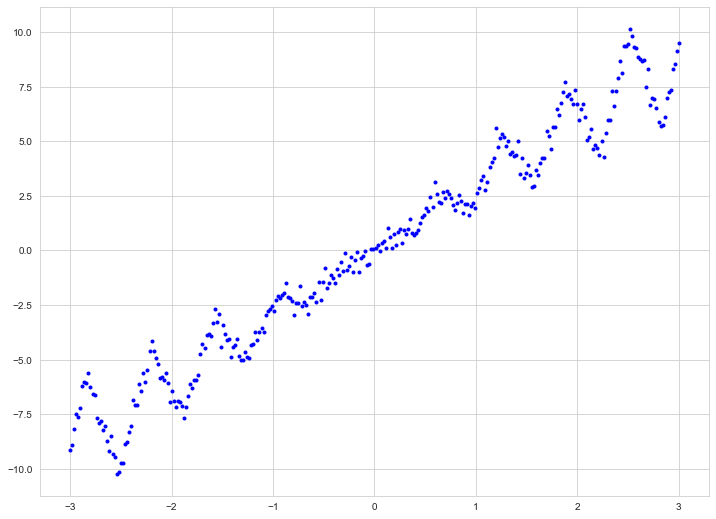

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

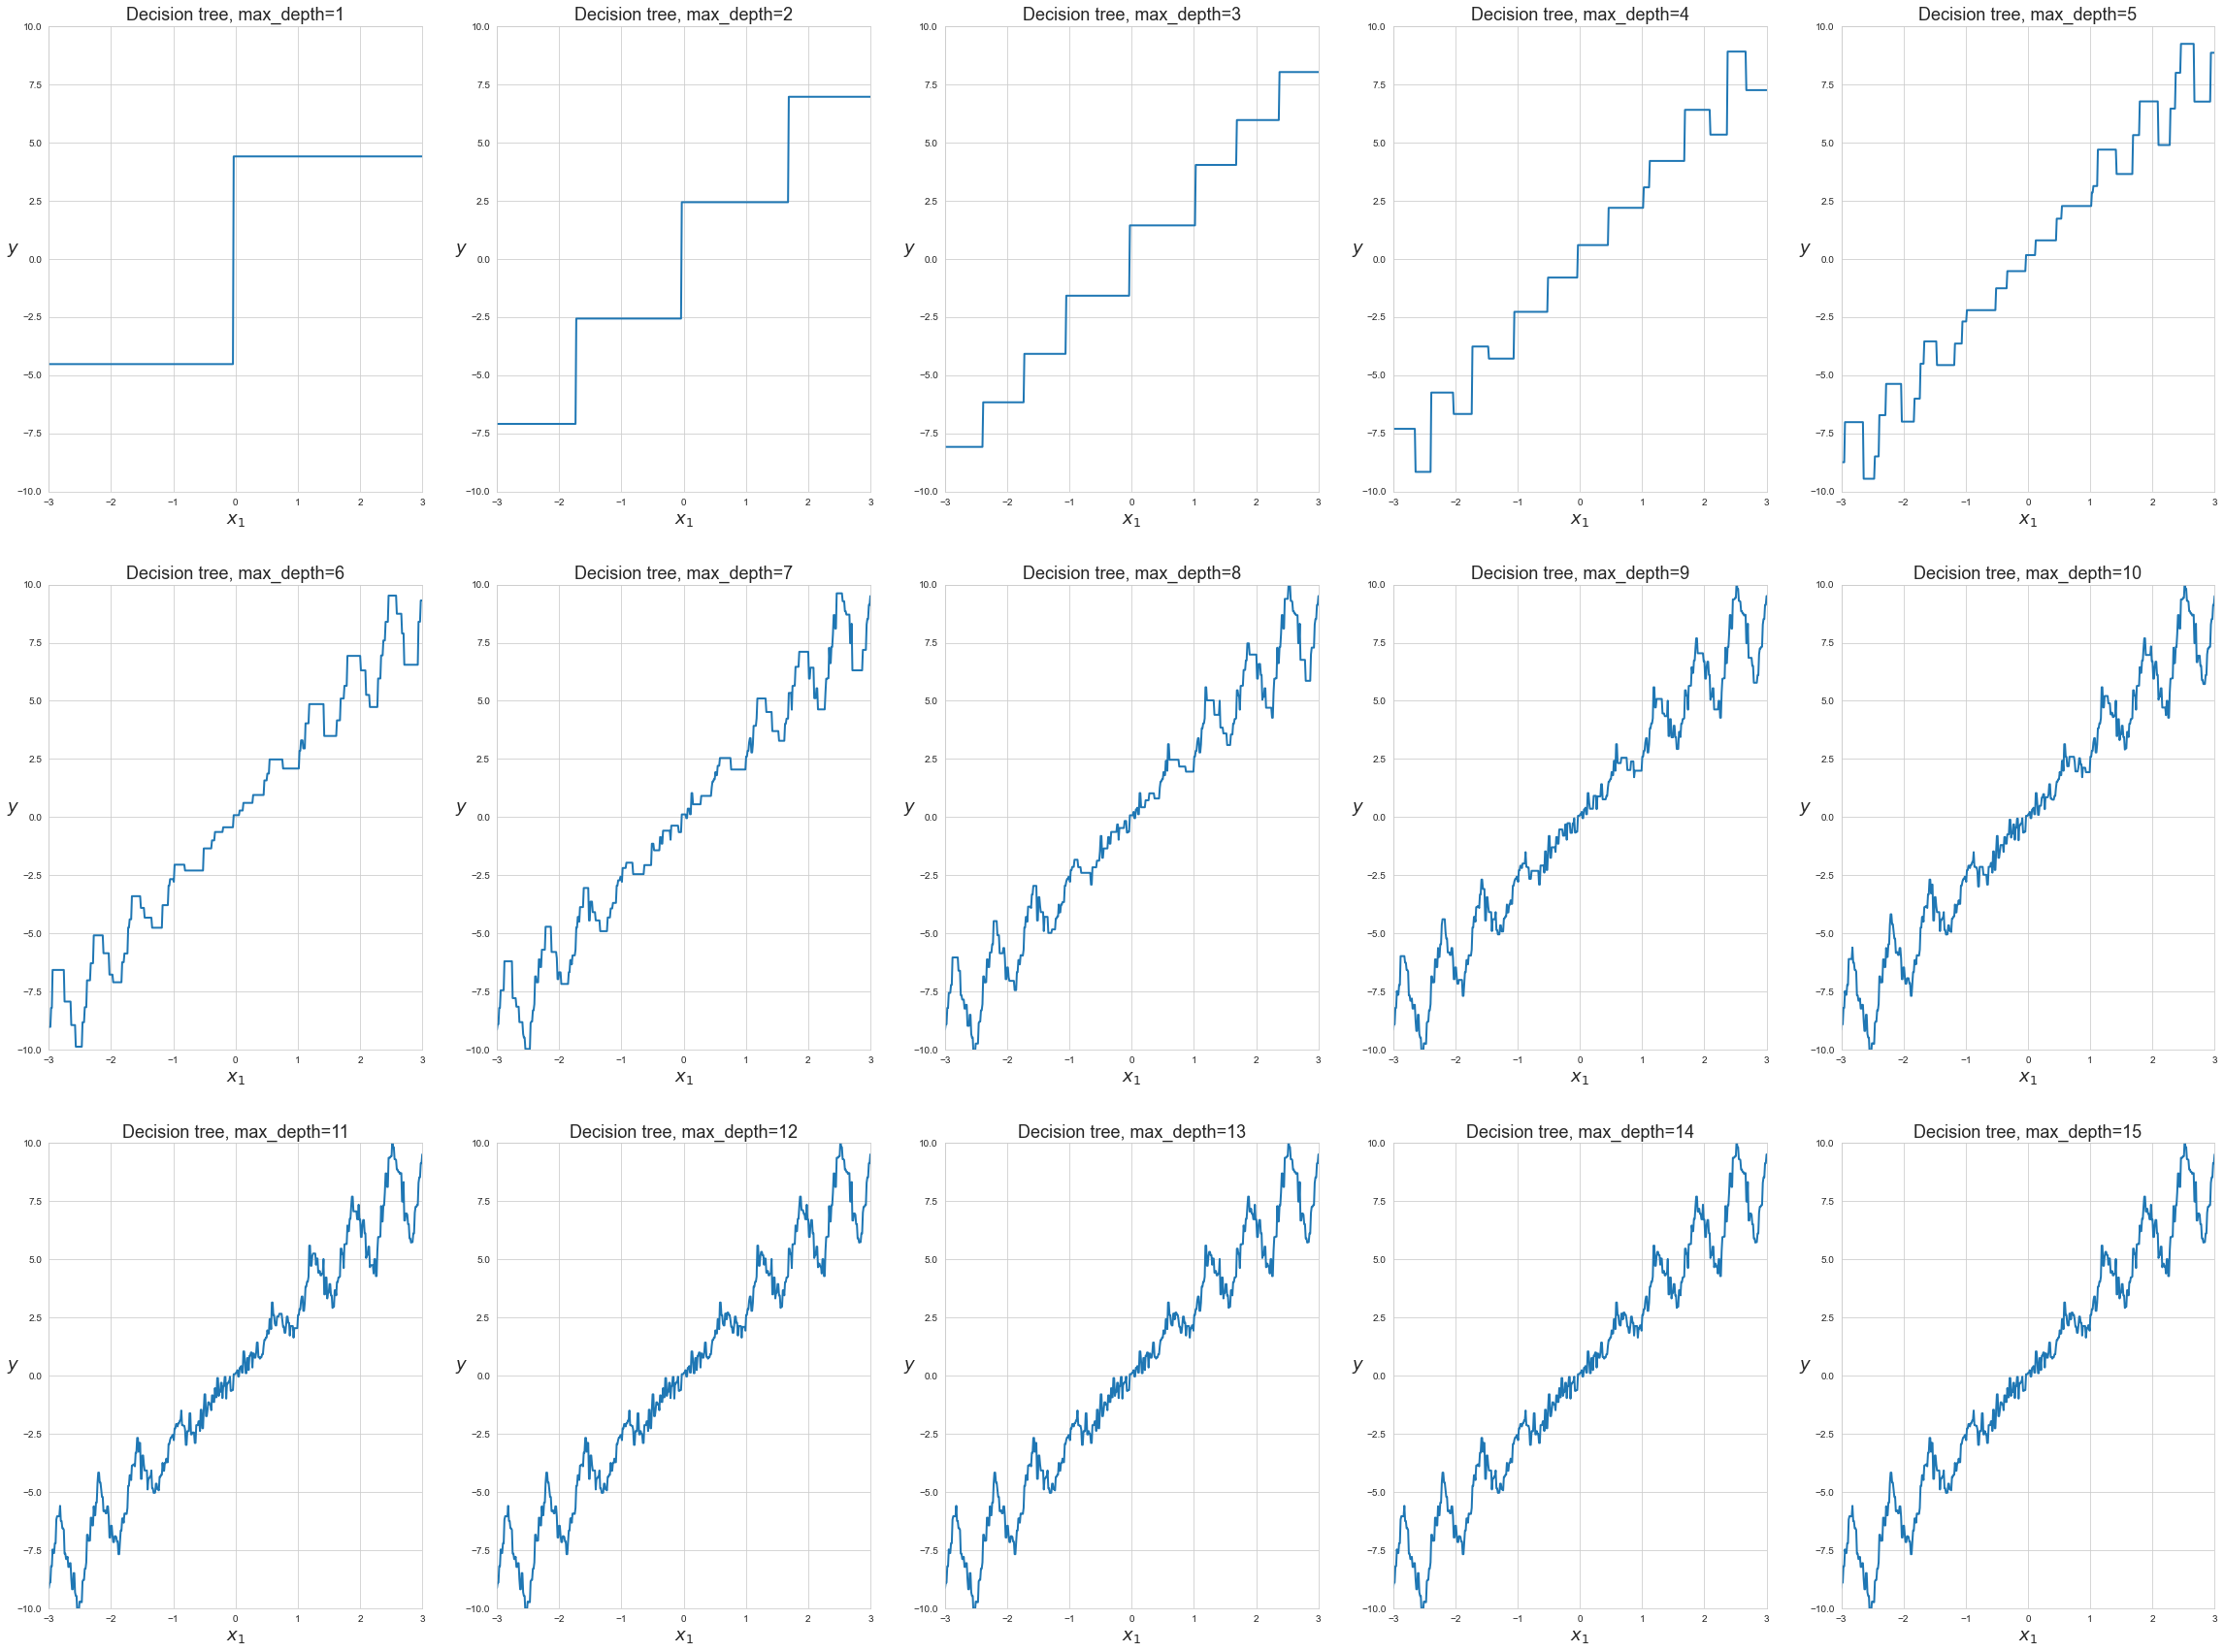

In [5]:
plt.figure(figsize=(40, 30))

for depth in range(1, 16):
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X, y)
    plt.subplot(3, 5, depth)
    plot_regression_predictions(dt, X, y)
    plt.title(f"Decision tree, max_depth={depth}", fontsize=18)


Модель хорошо определяет общую тенденцию при максимальной глубине 6 (может, 7), далее вероятно переобучение (ожидается высокая вариативность).

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

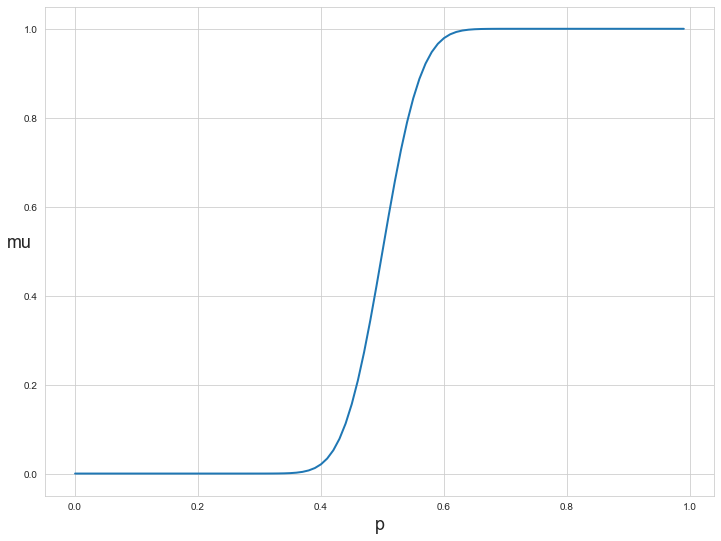

In [6]:
import math


def combinations(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))


mu_values = []
p_values = np.arange(0.0, 1.0, 0.01)
for p in p_values:
    mu = 0
    for i in range(51, 102):
        c = combinations(101, i)
        mu += c * (p ** i) * ((1 - p) ** (101 - i))
    mu_values.append(mu)
    

plt.xlabel("p", fontsize=18)
plt.ylabel("mu", fontsize=18, rotation=0)

plt.plot(p_values, mu_values, linewidth=2)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

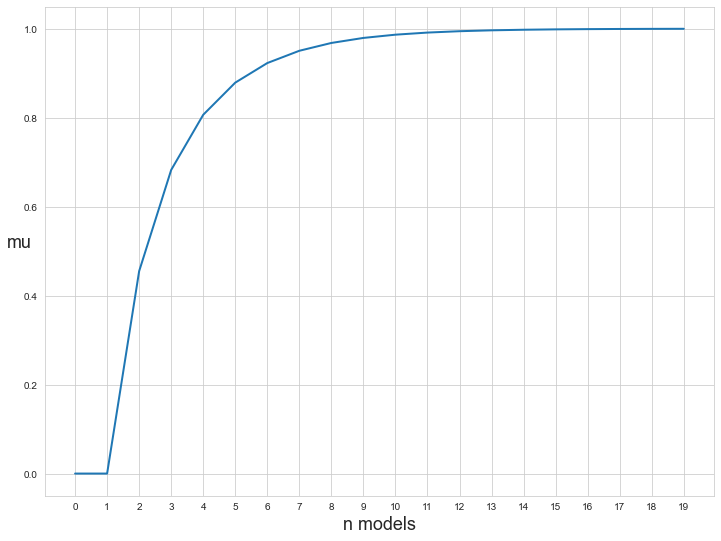

In [7]:
mu_values = []
p = 0.65

for n in range(20):
    mu = 0
    for i in range(1, n):
        c = combinations(n, i)
        mu += c * (p ** i) * ((1 - p) ** (n - i))
    mu_values.append(mu)
    

plt.xlabel("n models", fontsize=18)
plt.xticks(range(20))
plt.ylabel("mu", fontsize=18, rotation=0)

plt.plot(range(20), mu_values, linewidth=2)

Опишите ваши наблюдения:

* В первом случае вероятность правильно классифицировать объект при p < 0.4 близка к 0, при p > 0.6 близка к 1.
* Во втором случае при заданной вероятности (0.65), что одна модель правильно классифицирует объект, вероятность правильно классифицировать объект резко возрастает при n > 1, достигая значения, близкого к 1 при n ~ 11-12.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [150]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            
            # выбераем max_features признаков без возвращения/without replacement
            self.max_features = X.shape[1] if self.max_features is None else self.max_features
            selected_features = np.random.choice(list(range(X.shape[1])), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(selected_features)
            
            # создадим псевдовыборку при помощи бутстрэпа 
            n_samples = X.shape[0] # размер совпадает с исходной выборкой
            sample_indexes = np.random.randint(0, n_samples, size=n_samples)
            b_data = X[sample_indexes]
            b_labels = y[sample_indexes]
            
            # обучаем дерево решений
            dt_clsf = DecisionTreeClassifier(random_state=self.random_state, 
                                             max_depth=self.max_depth,
                                             max_features=self.max_features)
            dt_clsf.fit(b_data[:, selected_features], b_labels)
            self.trees.append(dt_clsf)        
        return self

    def predict_proba(self, X):
        predictions = []
        for tree, features in zip(self.trees, self.feat_ids_by_tree):
            prediction = tree.predict(X[:, features])
            predictions.append(prediction)
        return predictions
    
    def predict(self, X):
        probas = self.predict_proba(X)
        probas = np.concatenate([np.vstack(ar) for ar in probas], axis=1)
        
        u, indices = np.unique(probas, return_inverse=True)
        predictions = u[np.argmax(np.apply_along_axis(np.bincount, 1, indices.reshape(probas.shape), None, np.max(indices) + 1),
                  axis=1)]
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [40]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [78]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    accuracy = accuracy_metric(y, clf.predict(X))
    print(f'Accuracy={accuracy:.2f}')

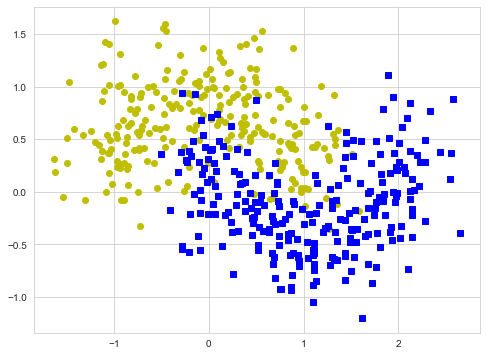

In [69]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [70]:
np.set_printoptions(threshold=np.inf)

rf_clsf = RandomForestClassifierCustom()
rf_clsf.fit(X, y)
predictions = rf_clsf.predict(X)

Accuracy=99.20


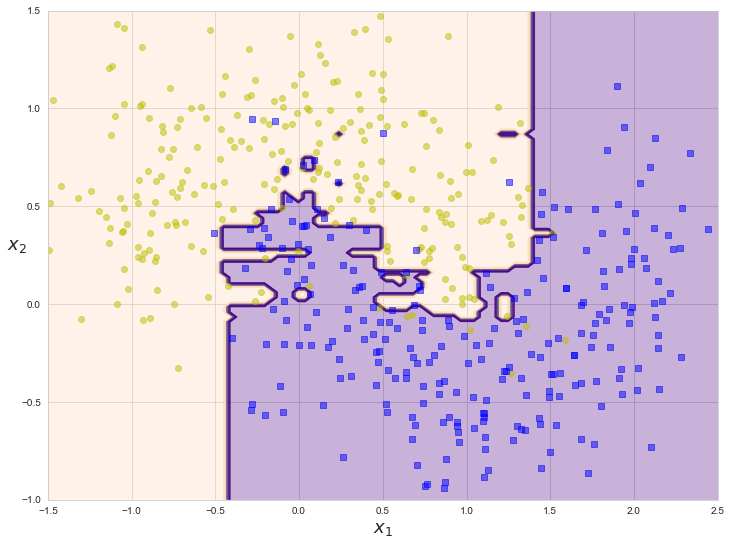

In [79]:
plot_decision_boundary(rf_clsf, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [61]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=1)

Accuracy=80.57
Accuracy=90.29
Accuracy=90.29
Accuracy=91.71
Accuracy=94.86
Accuracy=96.86
Accuracy=97.71
Accuracy=98.29
Accuracy=98.86
Accuracy=98.86
Accuracy=99.14
Accuracy=99.14
Accuracy=99.14
Accuracy=99.14
Accuracy=99.14


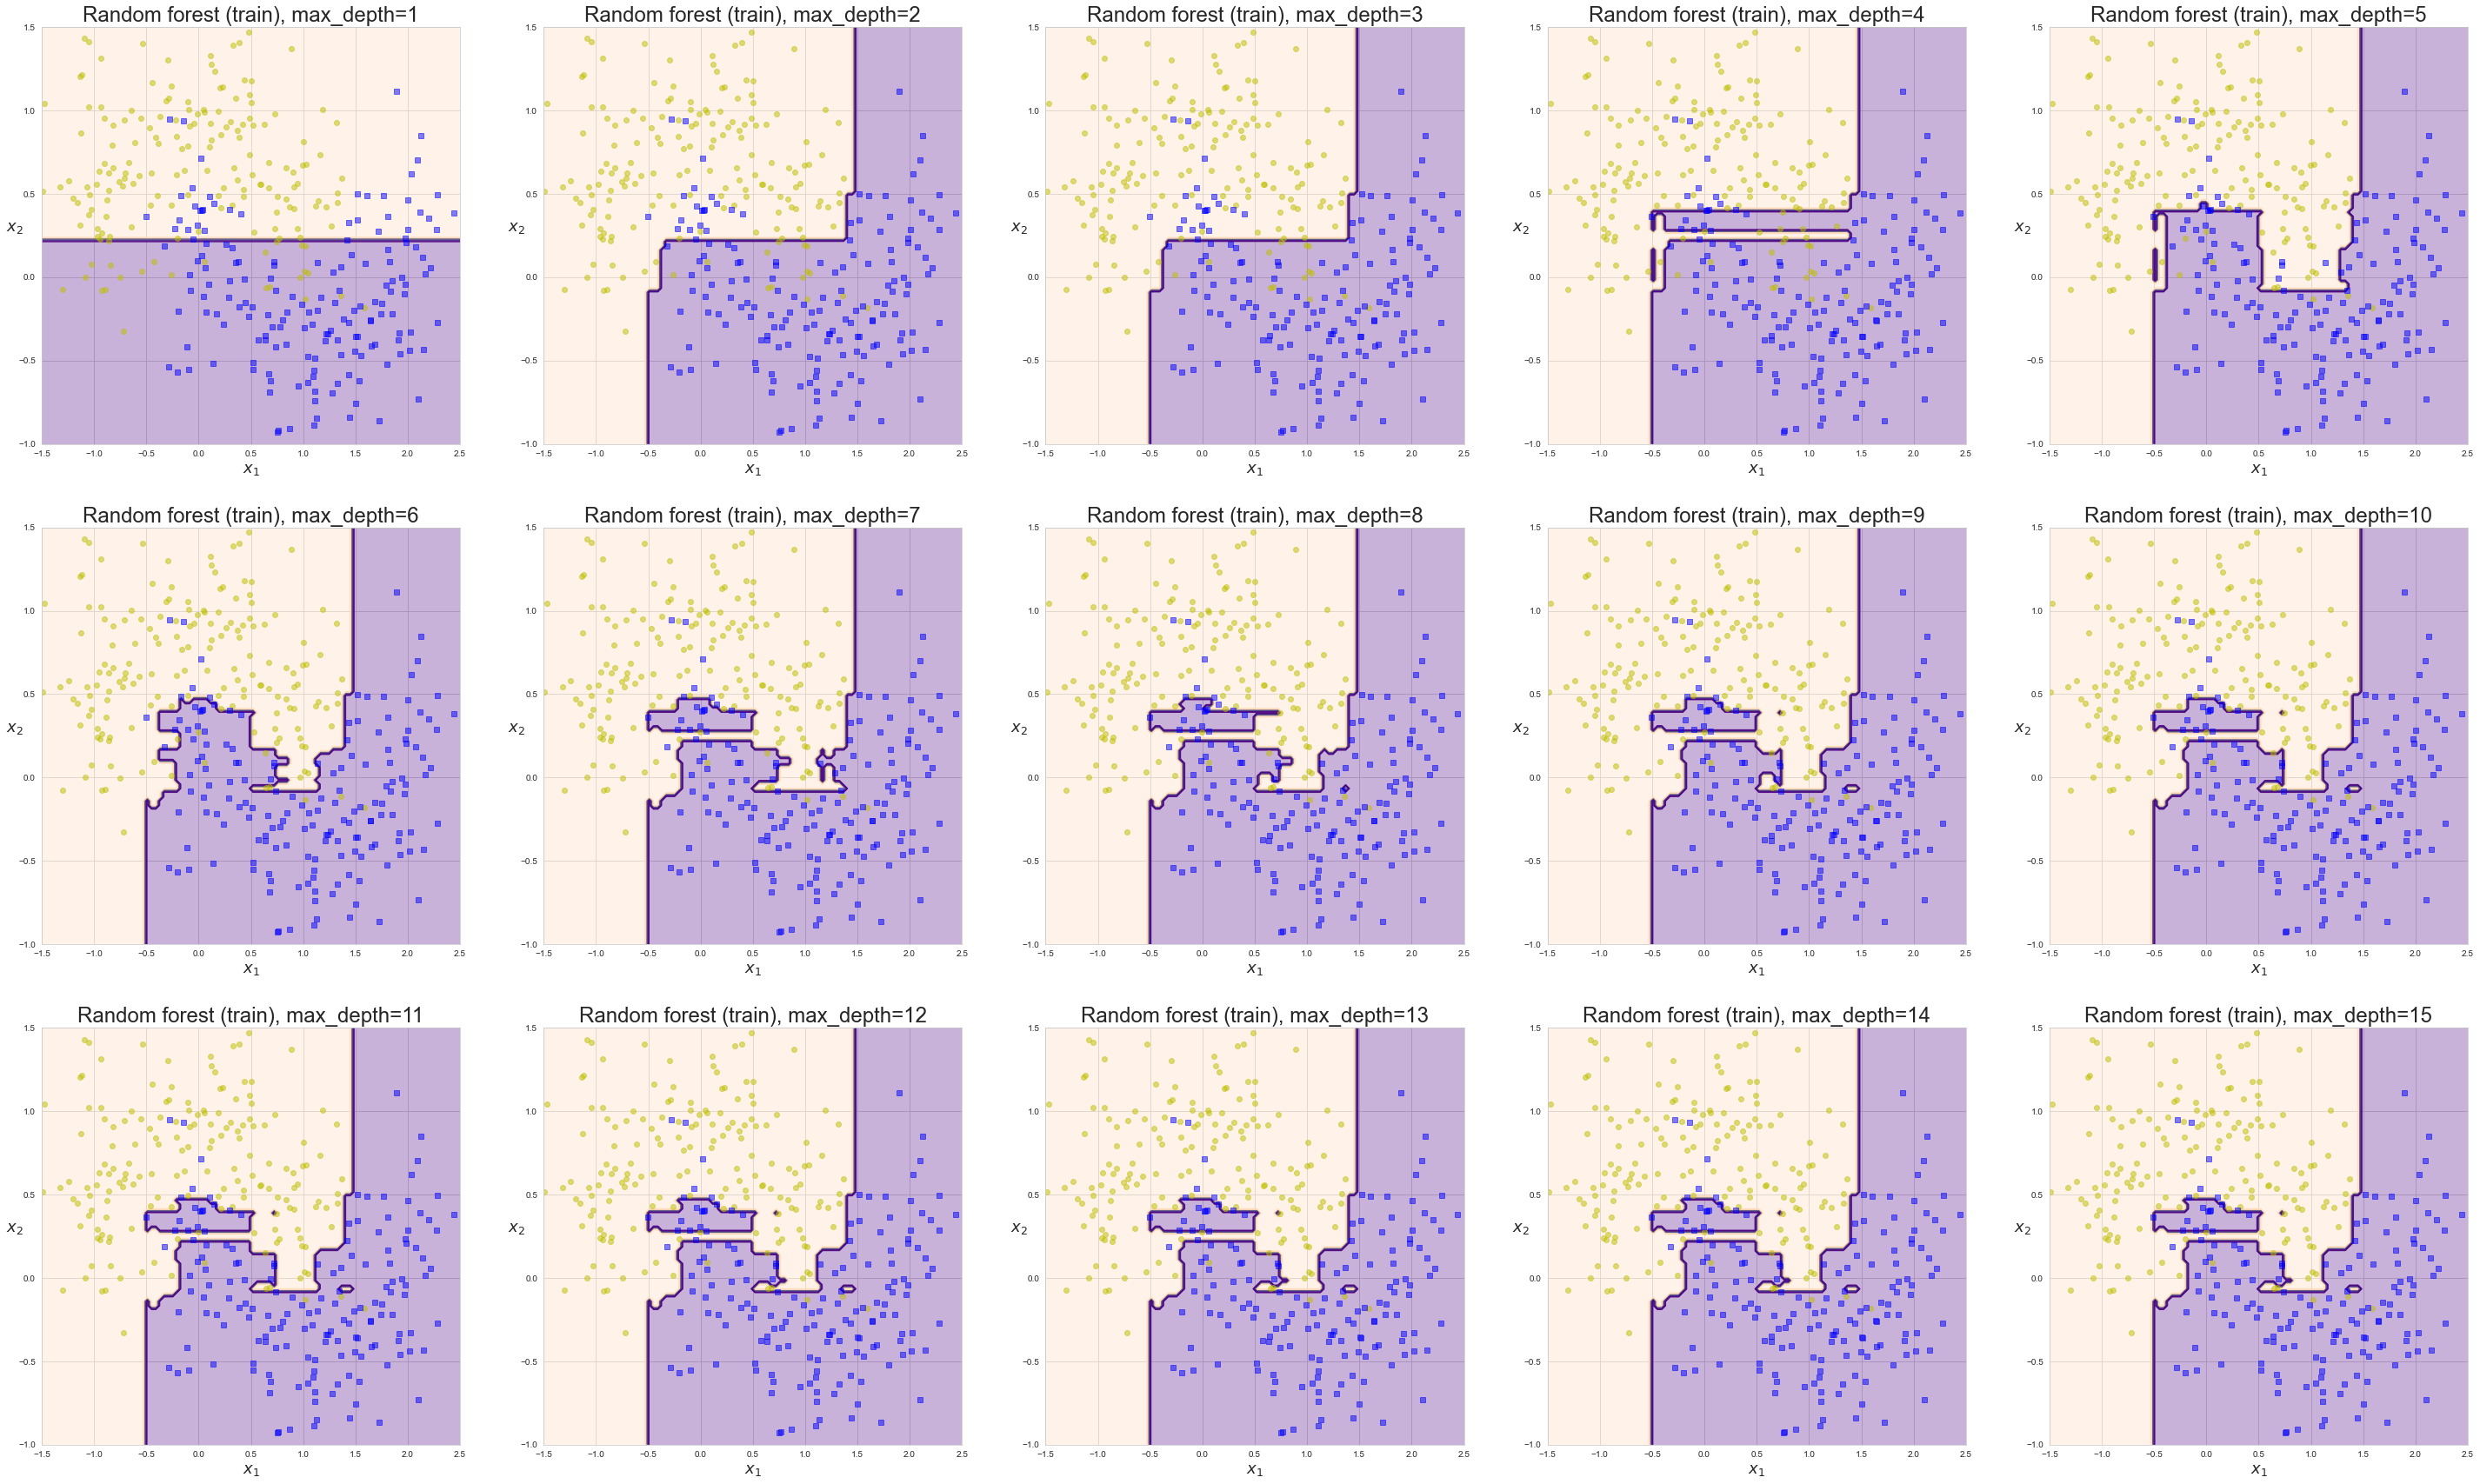

In [90]:
# Check different max_depth values (1-15) on train

plt.figure(figsize=(50, 30))
forests = []

for depth in range(1, 16):
    forest = RandomForestClassifierCustom(max_depth=depth)
    forest.fit(train_data, train_labels)
    forests.append(forest)
    plt.subplot(3, 5, depth)
    plot_decision_boundary(forest, train_data, train_labels)
    plt.title(f"Random forest (train), max_depth={depth}", fontsize=24)

На обучающей выборке наилучшие показатели точности достигаются при глубине 11, однако при таких значениях параметра может быть повышена вариативность.

Accuracy=80.67
Accuracy=86.00
Accuracy=86.00
Accuracy=86.67
Accuracy=90.67
Accuracy=90.67
Accuracy=90.67
Accuracy=90.00
Accuracy=88.00
Accuracy=90.00
Accuracy=88.67
Accuracy=90.00
Accuracy=90.00
Accuracy=90.00
Accuracy=90.00


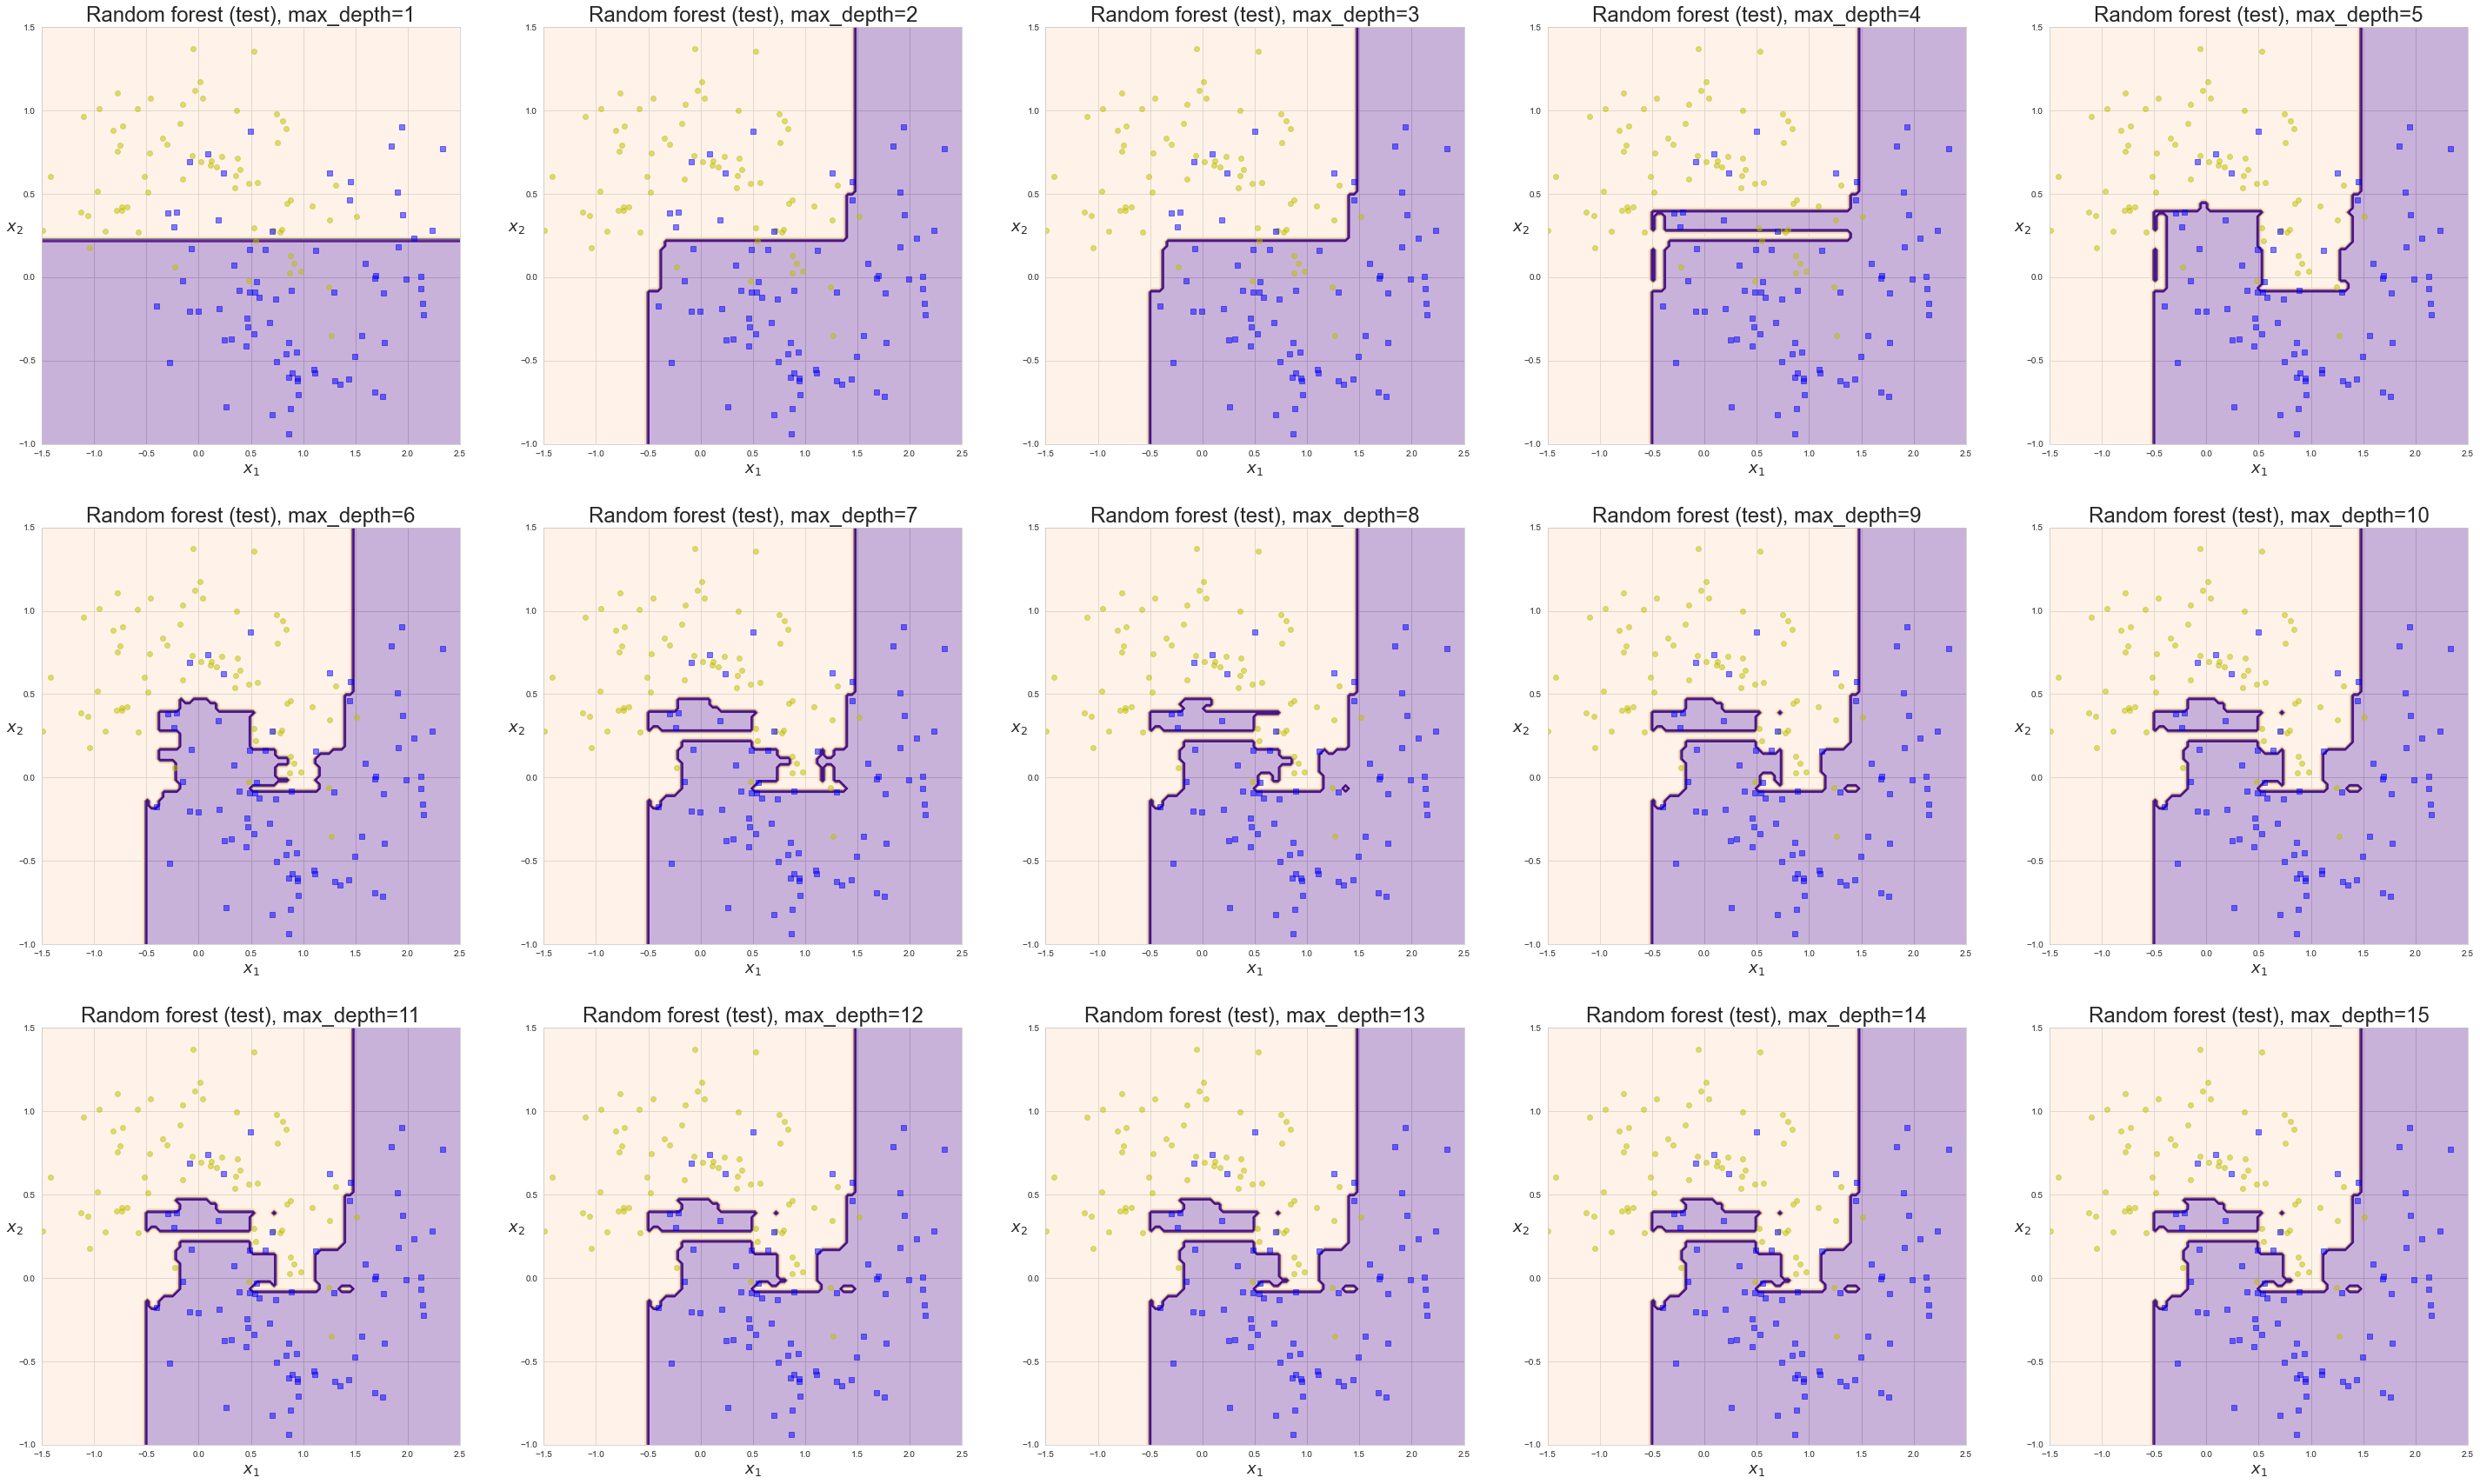

In [91]:
# Check models trained with different max_depth parameter on test

plt.figure(figsize=(50, 30))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plot_decision_boundary(forests[i], test_data, test_labels)
    plt.title(f"Random forest (test), max_depth={i+1}", fontsize=24)

На тестовой выборке наилучшие показатели точности достигаются при глубине 5-7, однако при максимальной глубине 12 и выше точность тоже высокая.

Accuracy=94.86
Accuracy=93.71
Accuracy=97.43
Accuracy=97.14
Accuracy=98.00
Accuracy=98.00
Accuracy=98.57
Accuracy=98.86
Accuracy=98.57
Accuracy=99.14
Accuracy=99.43
Accuracy=99.43
Accuracy=99.43
Accuracy=99.71
Accuracy=100.00


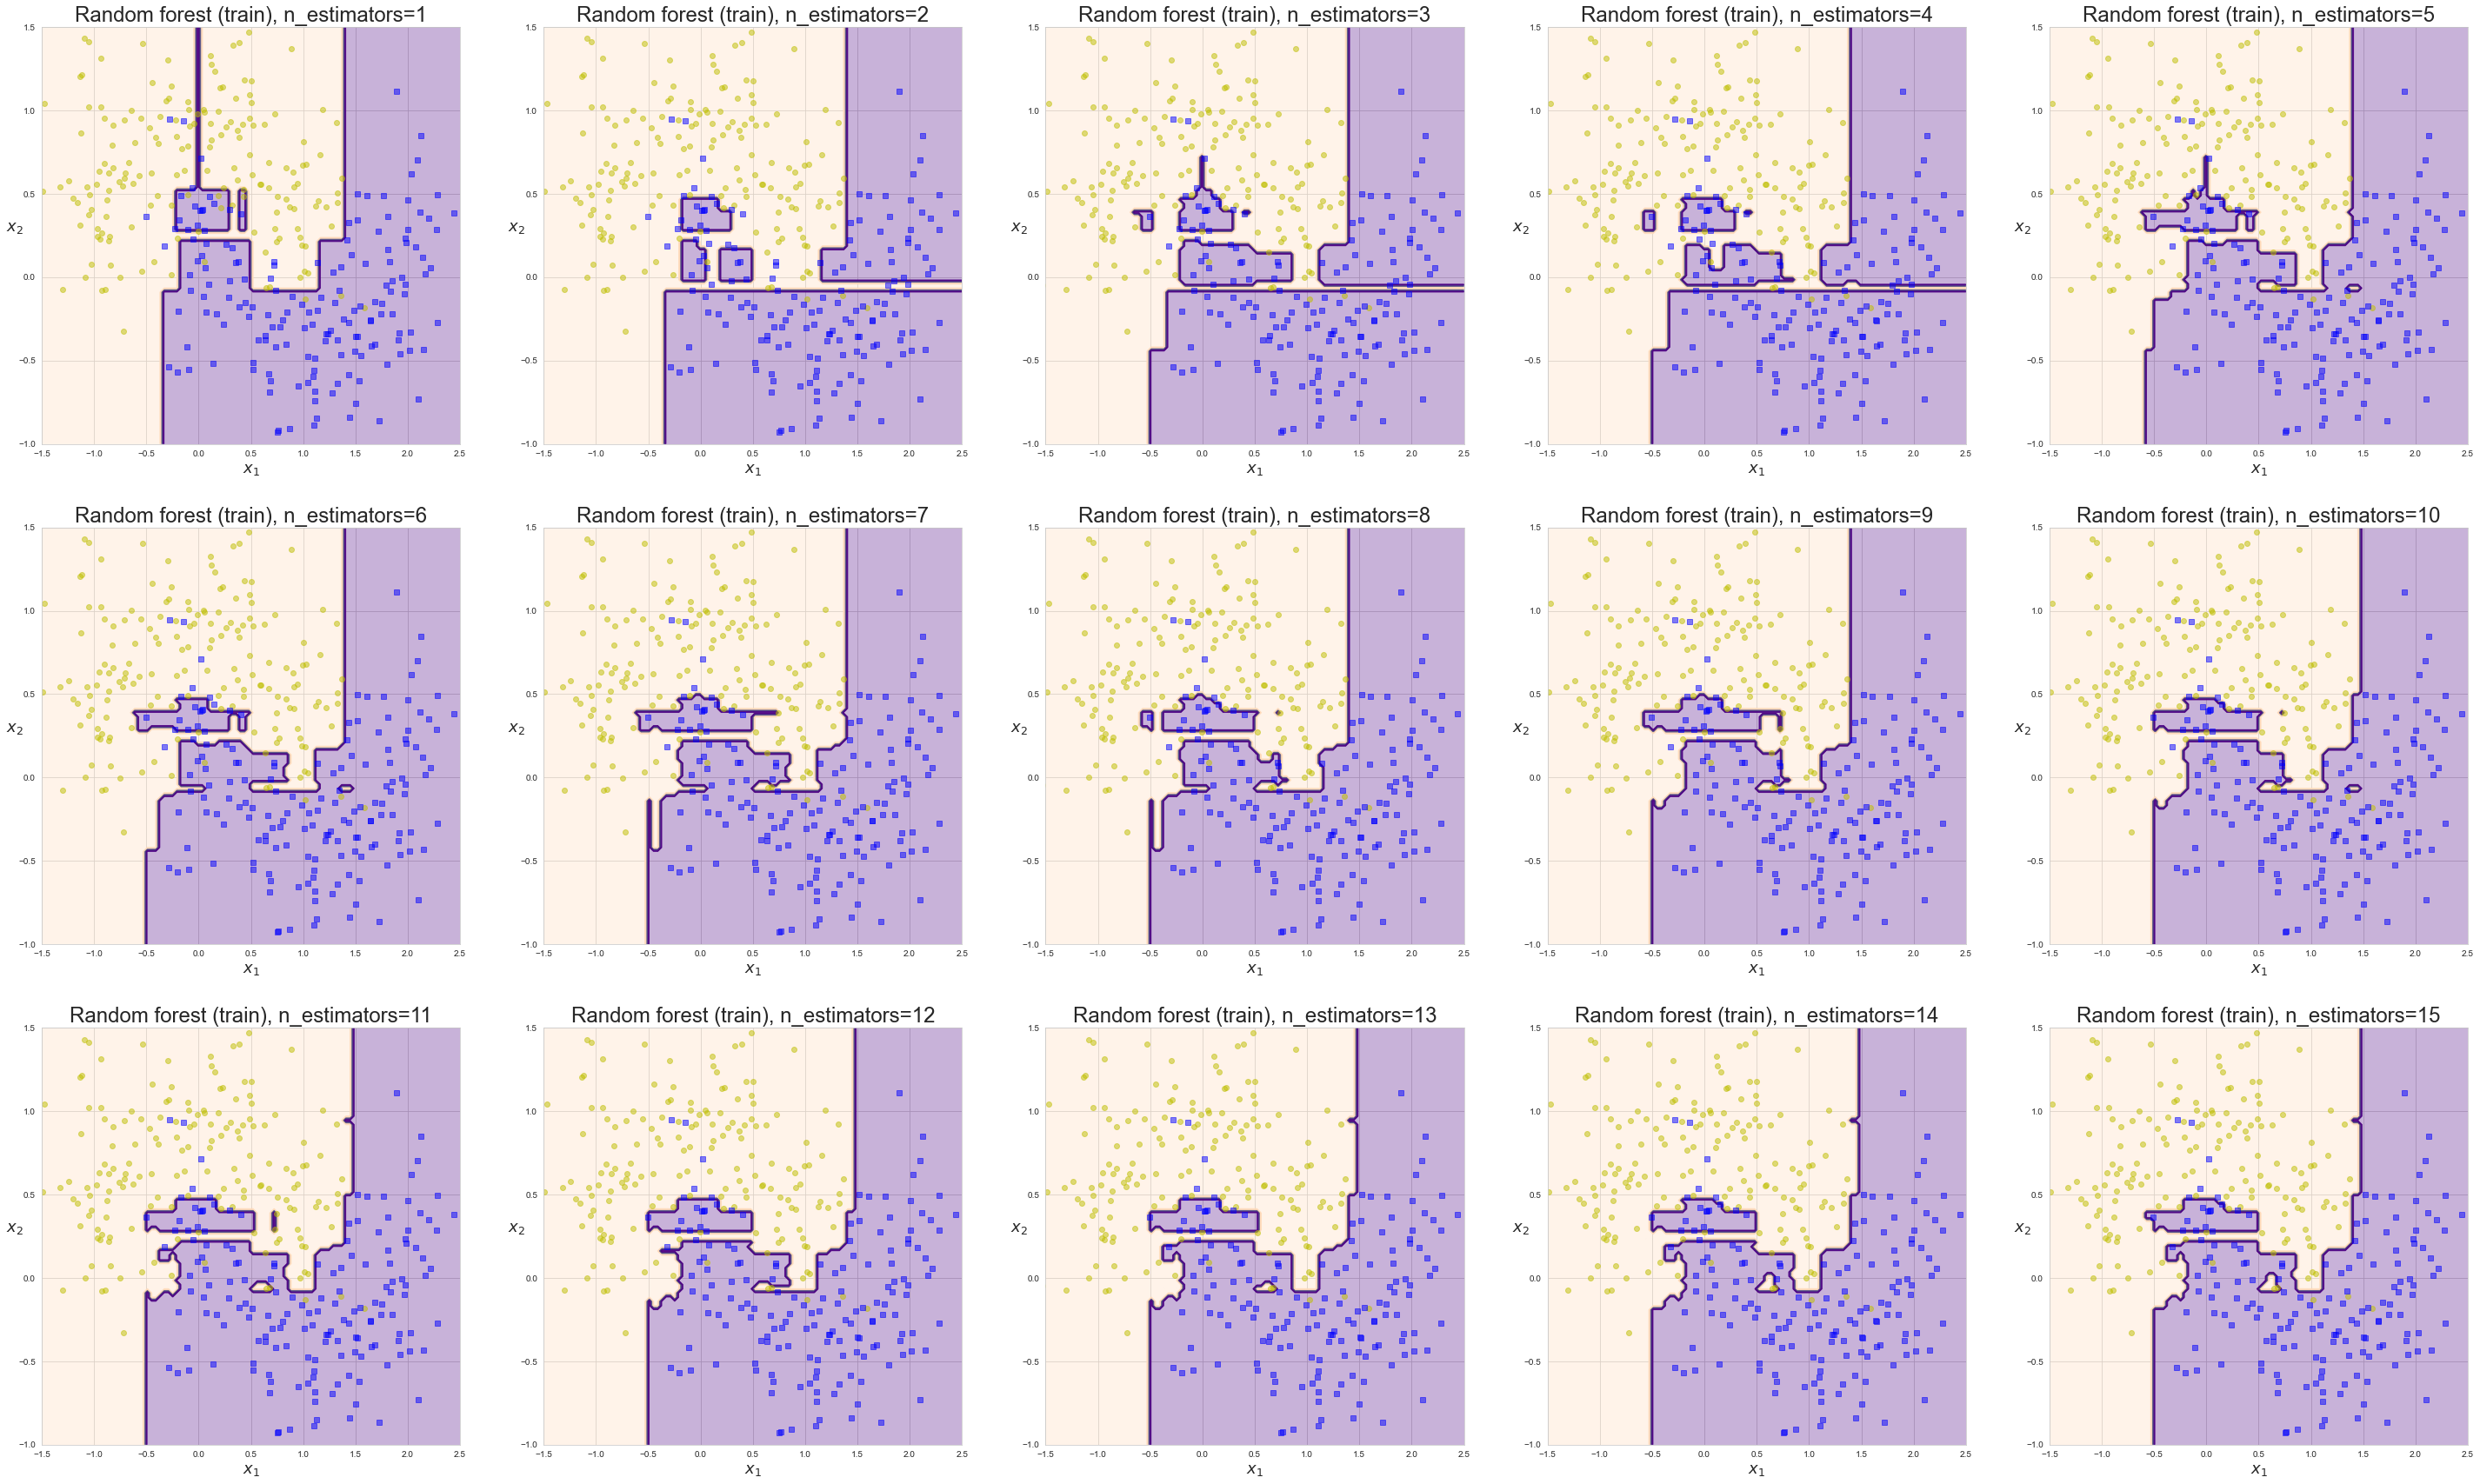

In [92]:
# Check different n_estimators values on train

plt.figure(figsize=(50, 30))
forests = []

for n in range(1, 16):
    forest = RandomForestClassifierCustom(max_depth=12, n_estimators=n)
    forest.fit(train_data, train_labels)
    forests.append(forest)
    plt.subplot(3, 5, n)
    plot_decision_boundary(forest, train_data, train_labels)
    plt.title(f"Random forest (train), n_estimators={n}", fontsize=24)

На обучающей выборке наилучшие показатели точности достигаются при количестве деревьев, равном 15, однако при таких значениях параметра может быть повышена вариативность - модель могла переобучиться.

Accuracy=87.33
Accuracy=88.67
Accuracy=90.00
Accuracy=90.67
Accuracy=90.67
Accuracy=91.33
Accuracy=90.67
Accuracy=90.67
Accuracy=89.33
Accuracy=90.00
Accuracy=90.67
Accuracy=88.67
Accuracy=90.00
Accuracy=90.00
Accuracy=90.67


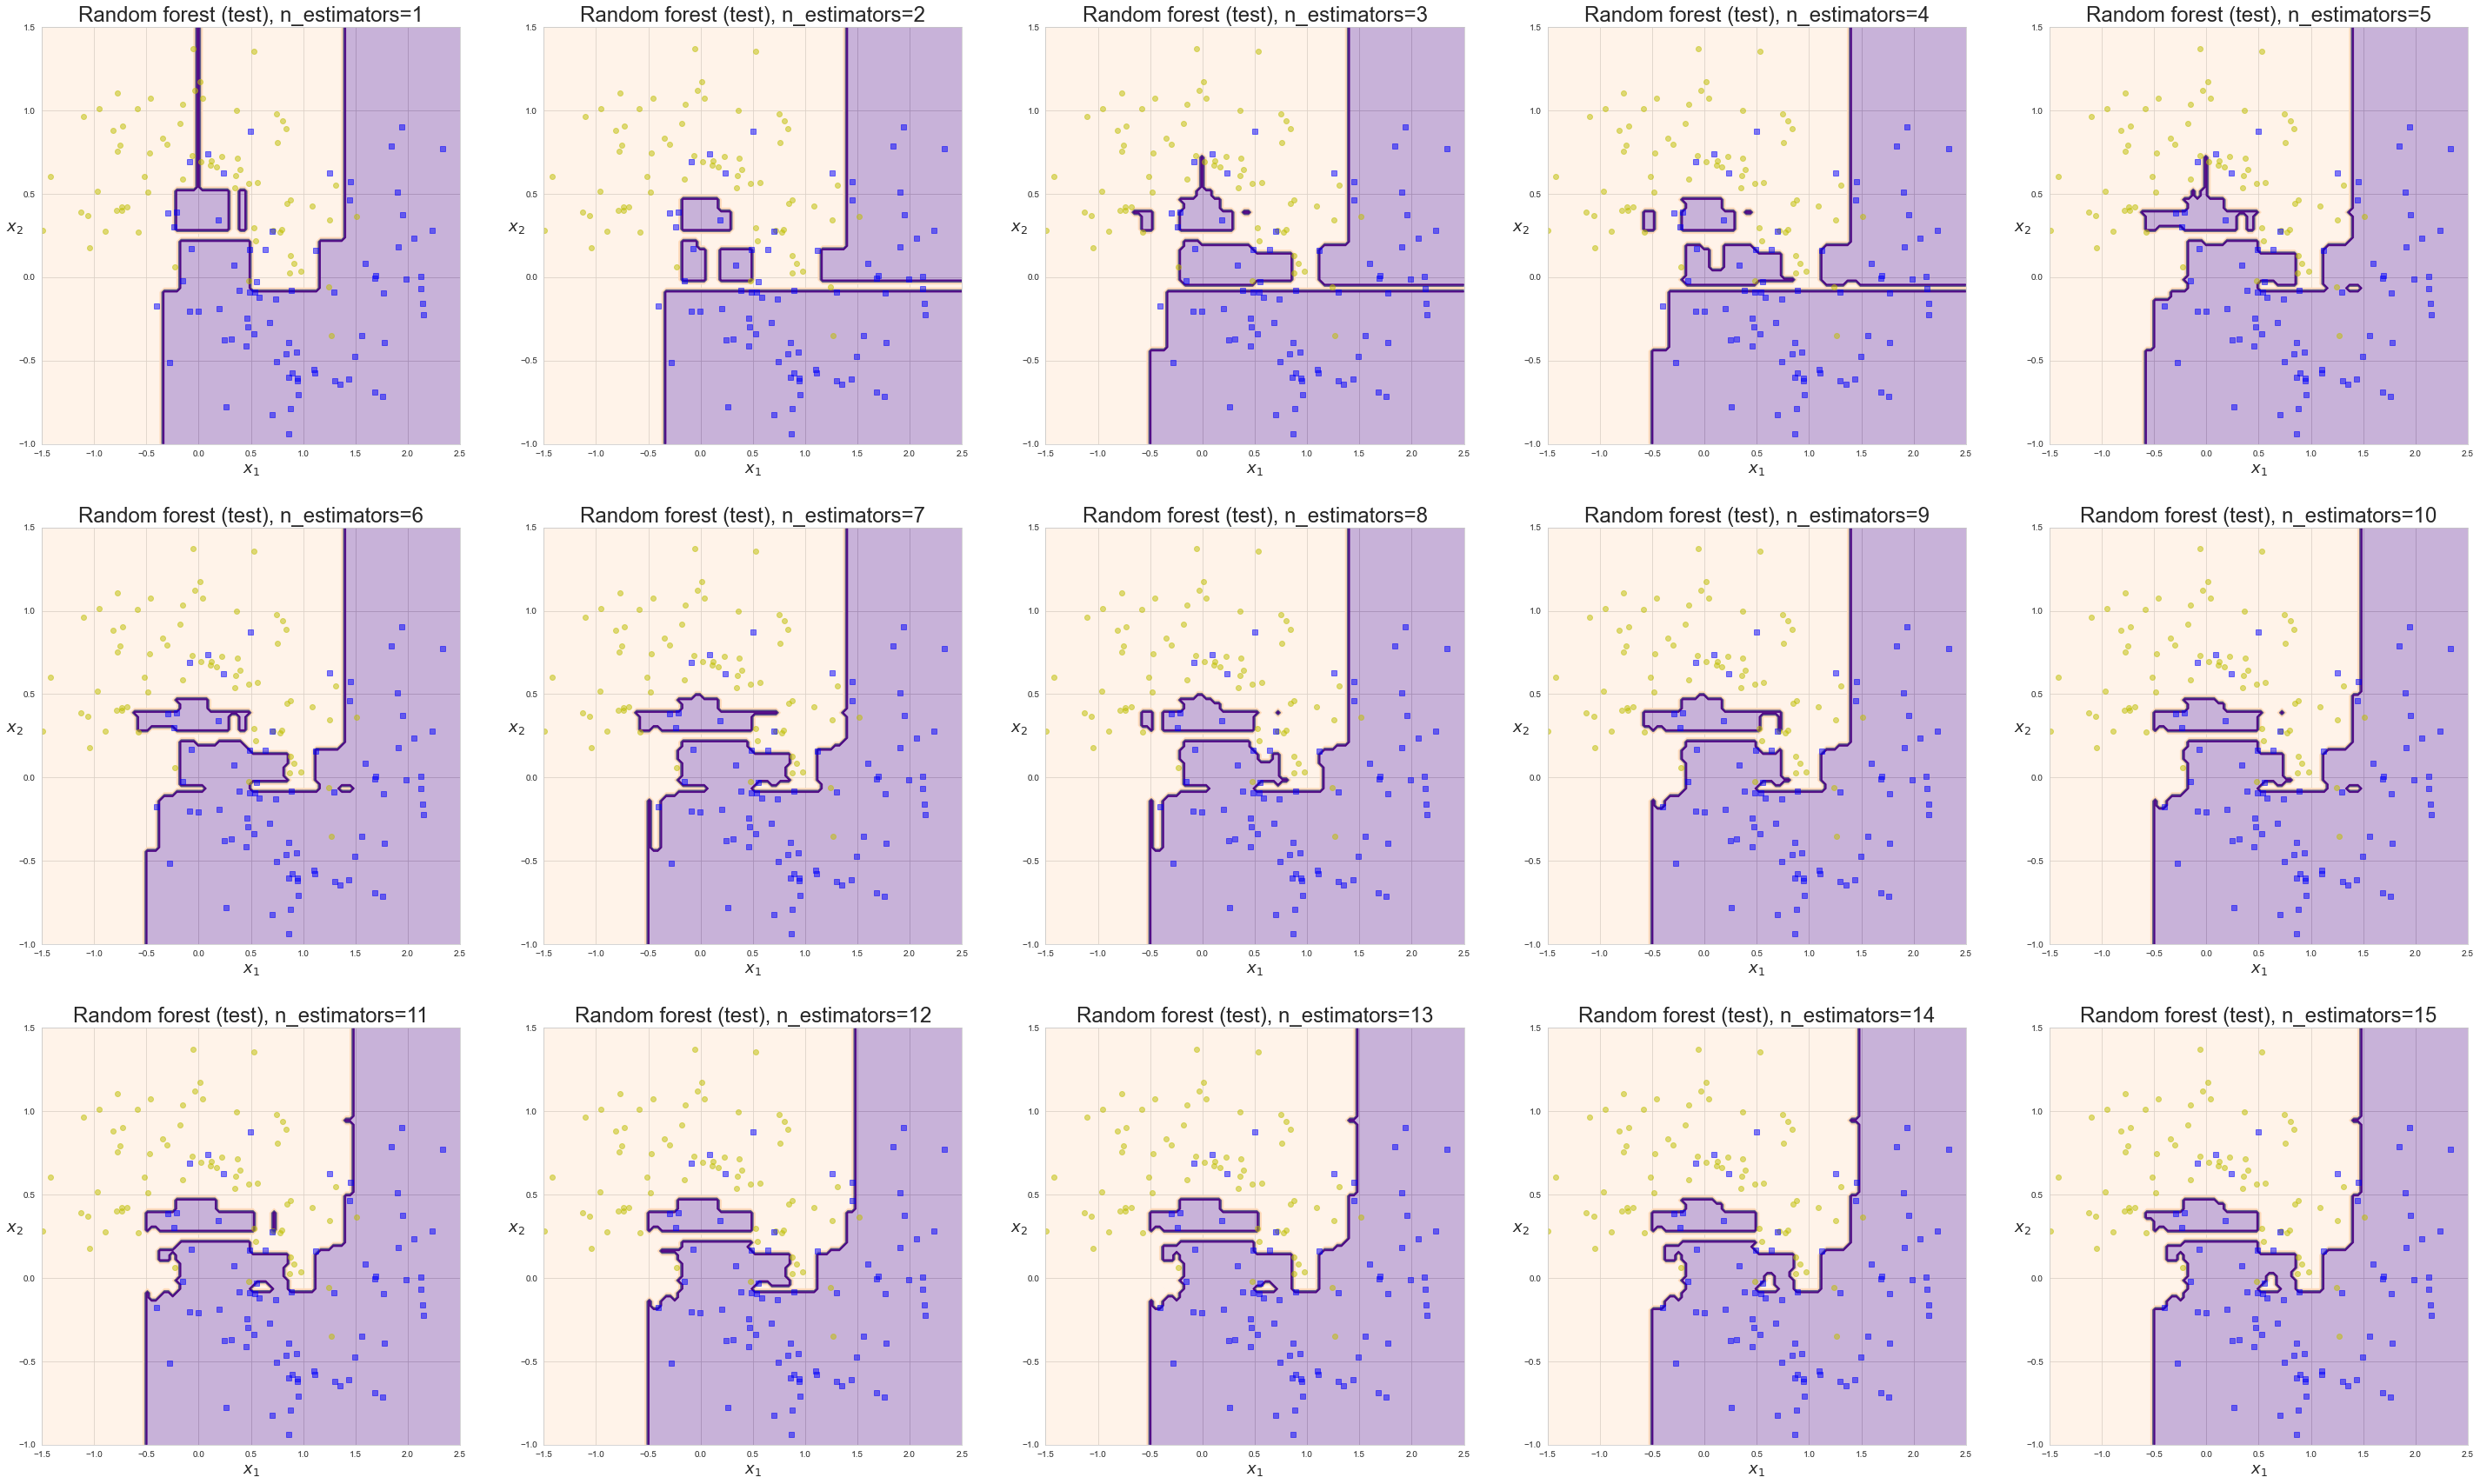

In [93]:
# Check models trained with different n_estimator parameter on test

plt.figure(figsize=(50, 30))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plot_decision_boundary(forests[i], test_data, test_labels)
    plt.title(f"Random forest (test), n_estimators={i + 1}", fontsize=24)

На тестовой выборке наилучшие показатели точности достигаются при количестве деревьев, равном 4, 5, 7, 8, 11, 12, 15.

Наилучшие показатели точности достигаются при количестве деревьев, равном 15, и максимальной глубине, равной 12.

Используем bootstrap_metric для оценки качества модели (код с лекции).

In [116]:
def bootstrap_metric(x,
                     y,
                     metric_fn,
                     samples_cnt=400,
                     alpha=0.05,
                     random_state=42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], 
                                 replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    return b_metric

In [161]:
from sklearn.metrics import mean_squared_error

def train_and_test_regressor(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        model.fit(X_train, y_train)
    predictions = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(y_test, 
                                      y_pred, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x, 
                                                                                y_pred=y))
        boot_scores[name] = boot_score
        
    results = pd.DataFrame(boot_scores)

    
    results = results.melt(value_vars=results.columns,
                           value_name="mse", 
                           var_name="model")

    return results

In [162]:
# check different n_estimators

models_rf = {}

for n_estimators in range(1, 21): 
    models_rf[f"RF{n_estimators}"] = RandomForestClassifierCustom(max_depth=12, n_estimators=n_estimators)

results_rf = train_and_test_regressor(models_rf, train_data, train_labels, test_data, test_labels)


Fitting RF1
Fitting RF2
Fitting RF3
Fitting RF4
Fitting RF5
Fitting RF6
Fitting RF7
Fitting RF8
Fitting RF9
Fitting RF10
Fitting RF11
Fitting RF12
Fitting RF13
Fitting RF14
Fitting RF15
Fitting RF16
Fitting RF17
Fitting RF18
Fitting RF19
Fitting RF20
Calculating bootstrap score for RF1
Calculating bootstrap score for RF2
Calculating bootstrap score for RF3
Calculating bootstrap score for RF4
Calculating bootstrap score for RF5
Calculating bootstrap score for RF6
Calculating bootstrap score for RF7
Calculating bootstrap score for RF8
Calculating bootstrap score for RF9
Calculating bootstrap score for RF10
Calculating bootstrap score for RF11
Calculating bootstrap score for RF12
Calculating bootstrap score for RF13
Calculating bootstrap score for RF14
Calculating bootstrap score for RF15
Calculating bootstrap score for RF16
Calculating bootstrap score for RF17
Calculating bootstrap score for RF18
Calculating bootstrap score for RF19
Calculating bootstrap score for RF20


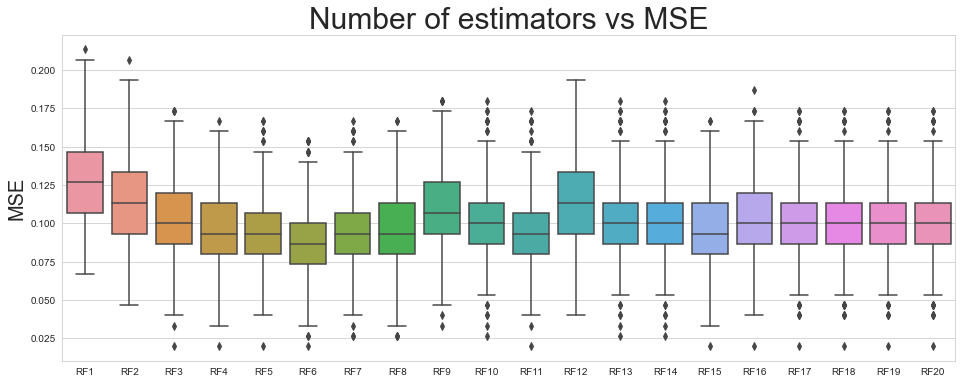

In [118]:
plt.figure(figsize=(16,6))
sns.boxplot(data=results_rf, y="mse", x="model")
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Number of estimators vs MSE", size=30)
plt.show()

In [120]:
# check different max_depth

models_rf = {}

for max_depth in range(1, 21): 
    models_rf[f"RF{max_depth}"] = RandomForestClassifierCustom(max_depth=max_depth, n_estimators=15)

results_rf = train_and_test_regressor(models_rf, train_data, train_labels, test_data, test_labels)

Fitting RF1
Fitting RF2
Fitting RF3
Fitting RF4
Fitting RF5
Fitting RF6
Fitting RF7
Fitting RF8
Fitting RF9
Fitting RF10
Fitting RF11
Fitting RF12
Fitting RF13
Fitting RF14
Fitting RF15
Fitting RF16
Fitting RF17
Fitting RF18
Fitting RF19
Fitting RF20
Calculating bootstrap score for RF1
Calculating bootstrap score for RF2
Calculating bootstrap score for RF3
Calculating bootstrap score for RF4
Calculating bootstrap score for RF5
Calculating bootstrap score for RF6
Calculating bootstrap score for RF7
Calculating bootstrap score for RF8
Calculating bootstrap score for RF9
Calculating bootstrap score for RF10
Calculating bootstrap score for RF11
Calculating bootstrap score for RF12
Calculating bootstrap score for RF13
Calculating bootstrap score for RF14
Calculating bootstrap score for RF15
Calculating bootstrap score for RF16
Calculating bootstrap score for RF17
Calculating bootstrap score for RF18
Calculating bootstrap score for RF19
Calculating bootstrap score for RF20


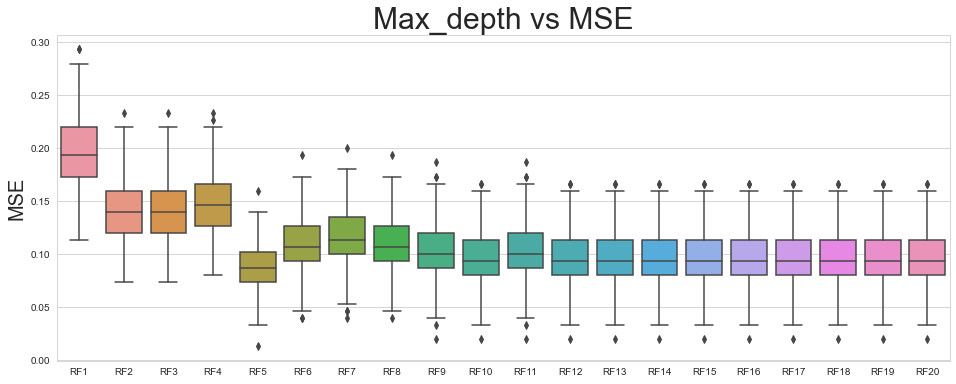

In [121]:
plt.figure(figsize=(16,6))
sns.boxplot(data=results_rf, y="mse", x="model")
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Max_depth vs MSE", size=30)
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [141]:
import itertools

In [152]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in itertools.combinations(enumerate(ensemble.trees), 2):
        Xi_test = X[:, ensemble.feat_ids_by_tree[i]]
        Xj_test = X[:, ensemble.feat_ids_by_tree[j]]

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [97]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [122]:
X.shape

(569, 30)

In [179]:
max_features_list = [1, 2, 3, 5, 10, 15, 20, 25, 30]
cor_dict = {}
for max_features in max_features_list:
    forest = RandomForestClassifierCustom(max_depth=12, n_estimators=15, max_features=max_features)
    forest.fit(X_train, y_train)
    cor_dict[max_features] = base_model_pair_correlation(forest, X)

cor_df_1 = pd.DataFrame(cor_dict)
cor_df_1

,1,2,3,5,10,15,20,25,30
0,0.461830,0.532640,0.788298,0.828996,0.895053,0.906831,0.902076,0.855799,0.844777
1,0.231580,0.385057,0.623934,0.631809,0.859918,0.880598,0.875839,0.884117,0.831693
2,0.661896,0.445794,0.745381,0.822518,0.878997,0.888458,0.891462,0.887654,0.829489
3,0.383815,0.465112,0.676327,0.807877,0.833011,0.873242,0.866322,0.851134,0.823058
4,0.328727,0.520523,0.781725,0.808990,0.869369,0.844135,0.855388,0.911085,0.821632
...,...,...,...,...,...,...,...,...,...
100,0.297949,0.411403,0.514868,0.777297,0.842146,0.832152,0.822241,0.843592,0.838521
101,0.334256,0.474939,0.443235,0.791404,0.894233,0.868723,0.876921,0.892088,0.906960
102,0.640376,0.747988,0.790685,0.799746,0.849021,0.806361,0.841631,0.831009,0.834177
103,0.615938,0.635862,0.578857,0.874845,0.879328,0.872880,0.874730,0.864228,0.849009


In [181]:
cor_df_1 = cor_df_1.melt(value_vars=cor_df_1.columns,
                           value_name="cor", 
                           var_name="max_features")
cor_df_1

,max_features,cor
0,1,0.461830
1,1,0.231580
2,1,0.661896
3,1,0.383815
4,1,0.328727
...,...,...
940,30,0.838521
941,30,0.906960
942,30,0.834177
943,30,0.849009


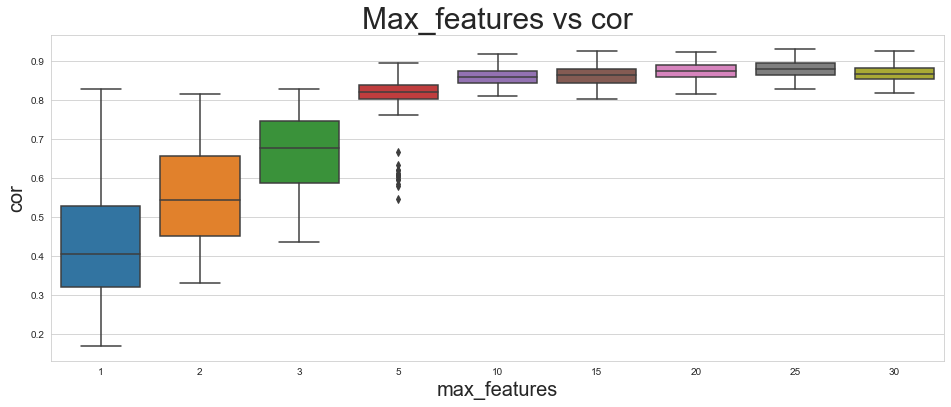

In [182]:
plt.figure(figsize=(16,6))
sns.boxplot(data=cor_df_1, y="cor", x="max_features")
plt.xlabel("max_features", size=20)
plt.ylabel("cor", size=20)
plt.title("Max_features vs cor", size=30)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [183]:
max_depths = range(1, 20)
cor_dict_2 = {}
for max_depth in max_depths:
    forest = RandomForestClassifierCustom(max_depth=max_depth, n_estimators=15, max_features=5)
    forest.fit(X_train, y_train)
    cor_dict_2[max_depth] = base_model_pair_correlation(forest, X)

cor_df_2 = pd.DataFrame(cor_dict_2)
cor_df_2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.887384,0.876435,0.880975,0.884574,0.852891,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996,0.828996
1,0.322118,0.462876,0.486090,0.570593,0.604121,0.610139,0.605669,0.616351,0.631809,0.631809,0.631809,0.631809,0.631809,0.631809,0.631809,0.631809,0.631809,0.631809,0.631809
2,0.823892,0.858476,0.818077,0.832499,0.832743,0.822130,0.826411,0.822518,0.822518,0.822518,0.822518,0.822518,0.822518,0.822518,0.822518,0.822518,0.822518,0.822518,0.822518
3,0.688957,0.740223,0.795812,0.815799,0.809026,0.786088,0.799964,0.804919,0.807877,0.807877,0.807877,0.807877,0.807877,0.807877,0.807877,0.807877,0.807877,0.807877,0.807877
4,0.875753,0.824109,0.848619,0.793768,0.809924,0.817291,0.818764,0.822395,0.808990,0.808990,0.808990,0.808990,0.808990,0.808990,0.808990,0.808990,0.808990,0.808990,0.808990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.879527,0.884702,0.832048,0.812103,0.815145,0.787620,0.792395,0.777297,0.777297,0.777297,0.777297,0.777297,0.777297,0.777297,0.777297,0.777297,0.777297,0.777297,0.777297
101,0.694524,0.804296,0.792447,0.787424,0.786375,0.798527,0.798688,0.792071,0.791404,0.791404,0.791404,0.791404,0.791404,0.791404,0.791404,0.791404,0.791404,0.791404,0.791404
102,0.669996,0.808242,0.821823,0.810095,0.777285,0.797059,0.810958,0.799746,0.799746,0.799746,0.799746,0.799746,0.799746,0.799746,0.799746,0.799746,0.799746,0.799746,0.799746
103,0.843942,0.888529,0.869156,0.847090,0.837281,0.848811,0.858294,0.875924,0.874845,0.874845,0.874845,0.874845,0.874845,0.874845,0.874845,0.874845,0.874845,0.874845,0.874845


In [184]:
cor_df_2 = cor_df_2.melt(value_vars=cor_df_2.columns,
                           value_name="cor", 
                           var_name="max_depth")
cor_df_2

,max_depth,cor
0,1,0.887384
1,1,0.322118
2,1,0.823892
3,1,0.688957
4,1,0.875753
...,...,...
1990,19,0.777297
1991,19,0.791404
1992,19,0.799746
1993,19,0.874845


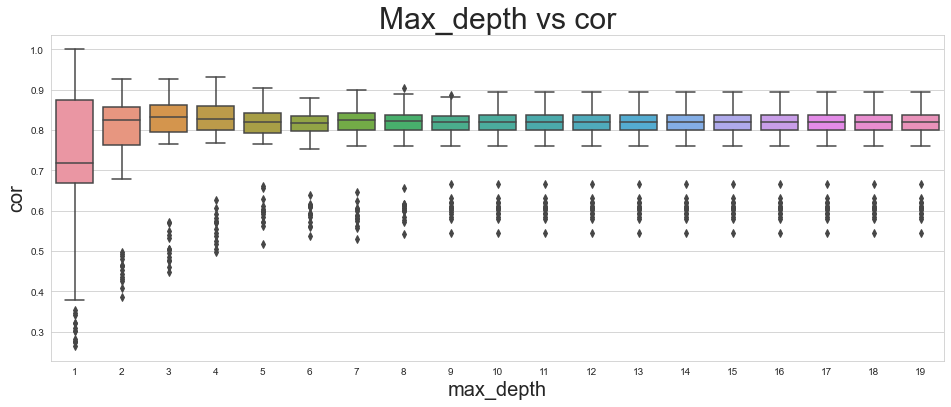

In [185]:
plt.figure(figsize=(16,6))
sns.boxplot(data=cor_df_2, y="cor", x="max_depth")
plt.xlabel("max_depth", size=20)
plt.ylabel("cor", size=20)
plt.title("Max_depth vs cor", size=30)
plt.show()

Опишите ваши наблюдения:

* Корреляция предсказаний базовых моделей минимальная при max_depth = 1 и max_features = 1 (до 5)

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [187]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("data/heart.csv")

In [188]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [190]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [191]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_hard = voting_hard.fit(X_train, y_train)

voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft = voting_soft.fit(X_train, y_train)

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[01:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8129461544095692
XGBRFClassifier: 0.8379629629629629
LGBMClassifier: 0.812123256860099
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8395804737268152
VotingClassifier: 0.8503633581946834

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [193]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in itertools.combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs


In [197]:
cor = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
cor.sort(key=lambda x: x[2], reverse=True)
cor

[(LGBMClassifier(random_state=111),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                gamma=0, gpu_id=-1, importance_type=None,
                interaction_constraints='', learning_rate=0.300000012,
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=4,
                num_parallel_tree=1, predictor='auto', random_state=111,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  0.9707360514467428),
 (ExtraTreesClassifier(random_state=111),
  0.9527199736215163),
 (SVC(kernel='linear', probability=True, random_state=111),
  LogisticRegression(max_iter=10000, solver='liblinear'),
  0.952158786094374),
 (<catboost.core.CatBoostClassifier at 0x1c5d4f9ed30>,
  LGBMClassifier(rando

In [222]:

base_models_2 = [("DT", dt),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr)]


voting_soft_2 = VotingClassifier(estimators=base_models_2, voting='soft')
voting_soft_2 = voting_soft_2.fit(X_train, y_train)

scores = cross_val_score(voting_soft_2, X_train, y_train, cv=3, scoring="f1")
print(f"{voting_soft_2.__class__.__name__}: {scores.mean()}")

[02:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [4]:
data = pd.read_csv("data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


**EDA**

In [5]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [8]:
object_features = data.select_dtypes(include='object').columns.tolist()
print(object_features)

['State', 'Phone', "Int'l Plan", 'VMail Plan', 'Churn?']


In [10]:
for i in object_features:
    print(data[i].value_counts())

WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
MD     70
KS     70
NC     68
NJ     68
MT     68
CO     66
NV     66
WA     66
RI     65
MA     65
MS     65
AZ     64
FL     63
MO     63
NM     62
ME     62
ND     62
NE     61
OK     61
DE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: State, dtype: int64
382-4657    1
348-7071    1
389-6082    1
415-3689    1
379-2503    1
           ..
352-1127    1
368-1288    1
403-5279    1
397-9333    1
400-4344    1
Name: Phone, Length: 3333, dtype: int64
no     3010
yes     323
Name: Int'l Plan, dtype: int64
no     2411
yes     922
Name: VMail Plan, dtype: int64
False.    2850
True.      483
Name: Churn?, dtype: int64


In [11]:
# Найдем повторяющиеся строки и удалим лишние.

data = data.drop_duplicates()

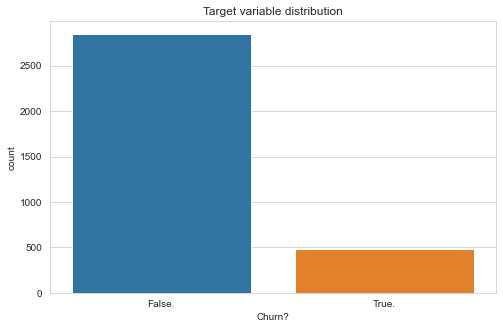

In [12]:
# Посмотрим распределение целевой переменной

plt.figure(figsize=(8, 5))
sns.countplot(x='Churn?', data=data)
plt.title('Target variable distribution')
plt.show()

Видим дисбаланс. Попробуем его устранить ниже.

**Обработка выбросов**

Создаем функцию outliers_number, расчитывающую количество выбросов, которая принимает выборку, а возвращает число выбросов, а также функцию outliers_to_median, заменяющюю выбросы на медианы. Функция outliers_to_median принимает датасет и название признака, по которому определяются выбросы. Концы усов boxplot рассчитываем как разность первого квартиля и полутора межквартильных расстояний и сумму третьего квартиля и полутора межквартильных расстояний соответственно.

Также создали функции remove_outlier, удаляющую выбросы, функцию outliers_clip, которая действует как np.clip, и функцию outliers_to_mean, заменяющую выбросы на средние значения.

In [15]:
def outliers_number(df_in, param_name):
    q1 = df_in[param_name].quantile(0.25)
    q3 = df_in[param_name].quantile(0.75)
    iqr = q3 - q1
    boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
    outliers = df_in[param_name].loc[(df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])]
    n = len(outliers)
    return n   


def remove_outlier(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        changed_data = df_in.loc[(df_in[param_name] >= boxplot_range[0]) & (df_in[param_name] <= boxplot_range[1])]
    return changed_data


def outliers_to_median(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        new_condition = (df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])
        feature_median = df_in[param_name].median()
        df_in.loc[new_condition, param_name] = feature_median
    return df_in
  
    
def outliers_to_mean(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        new_condition = (df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])
        condition_mean = (df_in[param_name] >= boxplot_range[0]) | (df_in[param_name] <= boxplot_range[1])
        feature_mean = df_in[param_name].mean()
        df_in.loc[new_condition, param_name] = feature_mean
    return df_in


def outliers_clip(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        condition_1 = (df_in[param_name] < boxplot_range[0]) 
        condition_2 = (df_in[param_name] > boxplot_range[1])
        df_in.loc[condition_1, param_name] = boxplot_range[0]
        df_in.loc[condition_1, param_name] = boxplot_range[1]
    return df_in


In [16]:
# Выбросы по всем количественным признакам

quantative_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
for el in quantative_features:
    print(f"Количество выбросов для признака {el}: {outliers_number(data, el)}")

Количество выбросов для признака Account Length: 18
Количество выбросов для признака Area Code: 0
Количество выбросов для признака VMail Message: 1
Количество выбросов для признака Day Mins: 25
Количество выбросов для признака Day Calls: 23
Количество выбросов для признака Day Charge: 25
Количество выбросов для признака Eve Mins: 24
Количество выбросов для признака Eve Calls: 20
Количество выбросов для признака Eve Charge: 24
Количество выбросов для признака Night Mins: 30
Количество выбросов для признака Night Calls: 22
Количество выбросов для признака Night Charge: 30
Количество выбросов для признака Intl Mins: 46
Количество выбросов для признака Intl Calls: 78
Количество выбросов для признака Intl Charge: 49
Количество выбросов для признака CustServ Calls: 267


In [172]:
# Заменим выбросы средние значения с помощью outliers_to_mean - (этот подход к работе с выбросами сработал лучше всего)

data_processed = outliers_to_mean(data, quantative_features)

**Обработка пропусков**

In [158]:
# Посмотрим, по каким признакам есть пропуски и сколько их


def get_nan_info(df):
    nan_dict = {}
    for i in df.columns:
        nan_values = df[i].isna().sum()
        if nan_values != 0:
            nan_dict[i] = nan_values
    print(nan_dict)
            

get_nan_info(data_processed)

{}


**Анализ признакового пространства**

In [173]:
target = 'Churn?'
features = data_processed.columns.drop(target).tolist()

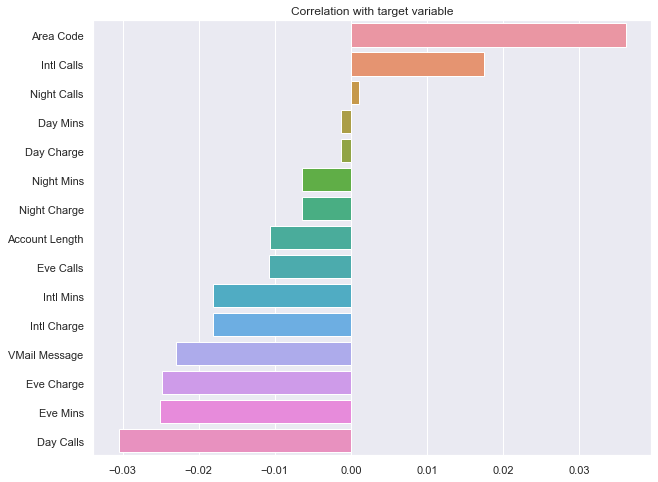

In [174]:
# Корреляция признаков с целевой переменной

corr_with_target = data_processed[features + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

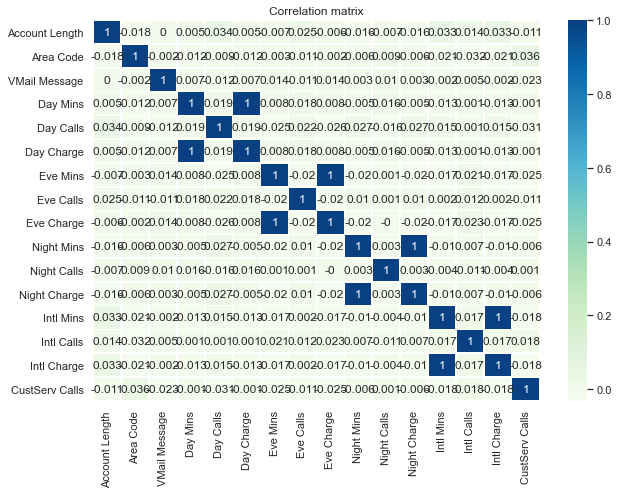

In [175]:
# Корреляция признаков

plt.figure(figsize = (10,7))

sns.set(font_scale=1.0)
sns.heatmap(data_processed[features].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [176]:
# Видим, что некоторые признаки сильно коррелируют - удалим некоторые

data_processed = data_processed.drop(columns=['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins'])
data_processed.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128.0,415.0,382-4657,no,yes,25.0,110.0,45.07,99.0,16.78000,91.0,11.01,3.0,2.70,1.0,False.
1,OH,107.0,415.0,371-7191,no,yes,26.0,123.0,27.47,103.0,16.62000,103.0,11.45,3.0,3.70,1.0,False.
2,NJ,137.0,415.0,358-1921,no,no,0.0,114.0,41.38,110.0,10.30000,104.0,7.32,5.0,3.29,0.0,False.
3,OH,84.0,408.0,375-9999,yes,no,0.0,71.0,50.90,88.0,17.08354,89.0,8.86,7.0,1.78,2.0,False.
4,OK,75.0,415.0,330-6626,yes,no,0.0,113.0,28.34,122.0,12.61000,121.0,8.41,3.0,2.73,3.0,False.


**Стандартизация, приведение типов, разбиение на train и test**

In [177]:
# Стандартизируем количественные данные

quantative_features = data_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
data_stand = data_processed.copy()
data_stand[quantative_features] = scaler.fit_transform(data_stand[quantative_features])
data_stand.head(5)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,0.709216,-0.523603,382-4657,no,yes,1.237649,0.485150,1.621046,-0.058000,-0.077172,-0.472918,0.906075,-0.594860,-0.111793,-0.343493,False.
1,OH,0.168932,-0.523603,371-7191,no,yes,1.310823,1.160894,-0.349446,0.149886,-0.115745,0.159445,1.108538,-0.594860,1.336602,-0.343493,False.
2,NJ,0.940766,-0.523603,358-1921,no,no,-0.591692,0.693071,1.207915,0.513686,-1.639389,0.212141,-0.791856,0.559734,0.742760,-1.413175,False.
3,OH,-0.422808,-0.688834,375-9999,yes,no,-0.591692,-1.542084,2.273771,-0.629686,-0.003993,-0.578312,-0.083234,1.714328,-1.444317,0.726189,False.
4,OK,-0.654359,-0.523603,330-6626,yes,no,-0.591692,0.641091,-0.252041,1.137343,-1.082487,1.107989,-0.290299,-0.594860,-0.068341,1.795871,False.


In [96]:
from sklearn.preprocessing import LabelEncoder

In [178]:
# Поменяем тип object на int для наших моделей

colnames = ['State', 'Phone', "Int'l Plan", 'VMail Plan', 'Churn?']

encode_df = data_stand[colnames]
encode_df = encode_df.astype('str')
encode_df = encode_df.apply(LabelEncoder().fit_transform)
data_encode_drop = data_stand.drop(colnames, axis = 1)
data_encode = pd.concat([data_encode_drop, encode_df], axis = 1)
    
data_encode[colnames].dtypes


State         int32
Phone         int32
Int'l Plan    int32
VMail Plan    int32
Churn?        int32
dtype: object

In [179]:
data_encode.head()

,Account Length,Area Code,VMail Message,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls,State,Phone,Int'l Plan,VMail Plan,Churn?
0,0.709216,-0.523603,1.237649,0.485150,1.621046,-0.058000,-0.077172,-0.472918,0.906075,-0.594860,-0.111793,-0.343493,16,1926,0,1,0
1,0.168932,-0.523603,1.310823,1.160894,-0.349446,0.149886,-0.115745,0.159445,1.108538,-0.594860,1.336602,-0.343493,35,1575,0,1,0
2,0.940766,-0.523603,-0.591692,0.693071,1.207915,0.513686,-1.639389,0.212141,-0.791856,0.559734,0.742760,-1.413175,31,1117,0,0,0
3,-0.422808,-0.688834,-0.591692,-1.542084,2.273771,-0.629686,-0.003993,-0.578312,-0.083234,1.714328,-1.444317,0.726189,35,1707,1,0,0
4,-0.654359,-0.523603,-0.591692,0.641091,-0.252041,1.137343,-1.082487,1.107989,-0.290299,-0.594860,-0.068341,1.795871,36,110,1,0,0


In [180]:
X_train, X_test, y_train, y_test = train_test_split(data_encode.drop(columns=target), data_encode[target], test_size=0.3,shuffle=True, random_state=42)


**Балансировка целевой переменной**

In [139]:
# Создадим сбалансированную выборку

def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == target_counts.index[minor_class_name]].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [181]:
data_encode[target].value_counts()

0    2850
1     483
Name: Churn?, dtype: int64

In [182]:
data_balanced = balance_df_by_target(data_encode, target)
    
data_balanced[target].value_counts()

0    2850
1    2415
Name: Churn?, dtype: int64

In [183]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_balanced.drop(columns=target), data_balanced[target], test_size=0.3,shuffle=True, random_state=42)

**Построение моделей**

In [60]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Model_1**

In [184]:
# xgb random forest (target not balanced)

model_xgbrf = xgboost.XGBRFClassifier(random_state=21)
model_xgbrf.fit(X_train, y_train)

y_train_pred = model_xgbrf.predict(X_train)
y_test_pred = model_xgbrf.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


[19:16:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1993
           1       0.95      0.70      0.80       340

    accuracy                           0.95      2333
   macro avg       0.95      0.85      0.89      2333
weighted avg       0.95      0.95      0.95      2333

TEST

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       857
           1       0.89      0.62      0.73       143

    accuracy                           0.93      1000
   macro avg       0.91      0.80      0.84      1000
weighted avg       0.93      0.93      0.93      1000

CONFUSION MATRIX

col_0

**Model_2**

In [185]:
# xgb random forest (target balanced)

model_xgbrf_2 = xgboost.XGBRFClassifier(random_state=21)
model_xgbrf_2.fit(X_train_2, y_train_2)

y_train_pred_2 = model_xgbrf_2.predict(X_train_2)
y_test_pred_2 = model_xgbrf_2.predict(X_test_2)

get_classification_report(y_train_2, y_train_pred_2, y_test_2, y_test_pred_2)

[19:16:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1965
           1       0.97      0.84      0.90      1720

    accuracy                           0.91      3685
   macro avg       0.92      0.91      0.91      3685
weighted avg       0.92      0.91      0.91      3685

TEST

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       885
           1       0.93      0.82      0.87       695

    accuracy                           0.89      1580
   macro avg       0.90      0.89      0.89      1580
weighted avg       0.90      0.89      0.89      1580

CONFUSION MATRIX

col_0

**Model_3**

In [186]:
# CatBoost (target not balanced)

model_catb = catboost.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred_3 = model_catb.predict(X_train)
y_test_pred_3 = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred_3, y_test, y_test_pred_3)


TRAIN

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1993
           1       1.00      0.85      0.92       340

    accuracy                           0.98      2333
   macro avg       0.99      0.92      0.95      2333
weighted avg       0.98      0.98      0.98      2333

TEST

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       857
           1       0.98      0.65      0.78       143

    accuracy                           0.95      1000
   macro avg       0.96      0.82      0.88      1000
weighted avg       0.95      0.95      0.94      1000

CONFUSION MATRIX

col_0     0   1
Churn?         
0       855   2
1        50  93


**Model_4**

In [187]:
# CatBoost (target balanced) 

model_catb_2 = catboost.CatBoostClassifier(silent=True, random_state=21)
model_catb_2.fit(X_train_2, y_train_2)

y_train_pred_4 = model_catb.predict(X_train_2)
y_test_pred_4 = model_catb.predict(X_test_2)

get_classification_report(y_train_2, y_train_pred_4, y_test_2, y_test_pred_4)

TRAIN

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1965
           1       1.00      0.79      0.88      1720

    accuracy                           0.90      3685
   macro avg       0.92      0.90      0.90      3685
weighted avg       0.92      0.90      0.90      3685

TEST

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       885
           1       1.00      0.78      0.88       695

    accuracy                           0.90      1580
   macro avg       0.93      0.89      0.90      1580
weighted avg       0.92      0.90      0.90      1580

CONFUSION MATRIX

col_0     0    1
Churn?          
0       883    2
1       151  544


**Выбор лучшей модели и подбор гиперпараметров**

Подберем гиперпараметры для моделей 3 и 4 и выберем лучший вариант.

In [192]:
# Подбор гиперпараметров для model_catb

model_catb = catboost.CatBoostClassifier(silent=True, random_state=21)

params = {'n_estimators':[10, 25, 50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 10, 13, 15, 17, 20]}

cv=KFold(n_splits=3, random_state=21, shuffle=True)

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)

rs.fit(X_train, y_train)

rs.best_params_

{'n_estimators': 500, 'max_depth': 5}

In [194]:
rs.best_score_

0.7582458079970517

In [193]:
# Подбор гиперпараметров для model_catb_2 (target сбалансирована)

model_catb_2 = catboost.CatBoostClassifier(silent=True, random_state=21)

rs_2 = RandomizedSearchCV(model_catb_2, params, scoring='f1', cv=cv, n_jobs=-1)

rs_2.fit(X_train_2, y_train_2)

rs_2.best_params_

{'n_estimators': 1500, 'max_depth': 7}

In [195]:
rs_2.best_score_

0.9602256932667381

**Обучение и оценка финальных моделей**

In [197]:
final_model = catboost.CatBoostClassifier(n_estimators=500, max_depth=5,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1993
           1       1.00      0.78      0.88       340

    accuracy                           0.97      2333
   macro avg       0.98      0.89      0.93      2333
weighted avg       0.97      0.97      0.97      2333

TEST

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       857
           1       0.97      0.66      0.78       143

    accuracy                           0.95      1000
   macro avg       0.96      0.83      0.88      1000
weighted avg       0.95      0.95      0.94      1000

CONFUSION MATRIX

col_0     0   1
Churn?         
0       854   3
1        49  94


In [199]:
final_model_2 = catboost.CatBoostClassifier(n_estimators=1500, max_depth=7,
                                      silent=True, random_state=21)
final_model_2.fit(X_train_2, y_train_2)

y_train_pred_2 = final_model.predict(X_train_2)
y_test_pred_2 = final_model.predict(X_test_2)

get_classification_report(y_train_2, y_train_pred_2, y_test_2, y_test_pred_2)

TRAIN

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1965
           1       1.00      0.76      0.86      1720

    accuracy                           0.89      3685
   macro avg       0.91      0.88      0.88      3685
weighted avg       0.91      0.89      0.88      3685

TEST

              precision    recall  f1-score   support

           0       0.83      1.00      0.90       885
           1       0.99      0.74      0.85       695

    accuracy                           0.88      1580
   macro avg       0.91      0.87      0.88      1580
weighted avg       0.90      0.88      0.88      1580

CONFUSION MATRIX

col_0     0    1
Churn?          
0       882    3
1       183  512


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

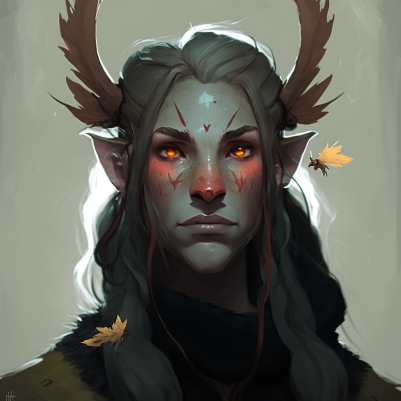

In [201]:
from IPython.display import Image

# Вот рисунок midjourney - мой персонаж в ДнД :)

Image("data/firbolg_mj.png")

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Спасибо за интересное задание!